# ENEM - Regressão e Agrupamento

#### Graduação Engenharia de Computação
- **Gabriel Soares Baptista** - 2018102117
- **Humberto Giuri Calente** - 2018103846
- **João Lucas Luz** - 2018103212

## Introdução

O Exame Nacional do Ensino Médio (Enem) é a maior prova do país em relação a quantidade de inscritos. Ela teve, apenas em 2020, mais de 2 milhões de participantes, pertencentes aos mais diversos contextos sociais, faixas etárias e grupos étnico-raciais

Infelizmente, esses diferentes contextos representam diferenças de oportunidade, qualidade de ensino e privilégios entre os estudantes que realizam o exame. Logo, é de se entender que a realidade social experienciada por uma pessoa reflete no seu desempenho da prova.

Dessa forma, entende-se que é de grande importância realizar a caracterização dos dados referentes aos desempenhos dos participantes em comparação com os contextos socio-econômicos que os mesmos se encontram. Com isso, espera-se encontrar informações que auxiliem na compreensão dos problemas existentes no âmbito da educação e que fomentem o debate sobre essas questões.

## Definição do Problema

A prova avalia conteúdos em 5 grandes áreas: Matemática, Ciências da Natureza, Ciências Humanas, Linguagens e Redação. No final, os participantes possuem 5 notas entre, aproximadamente, 0 e 1000 (uma para cada área avaliada).

O problema a ser resolvido pode ser quebrado em duas seções:

1. Aplicar regressão para obter um modelo que prediz a nota de matemática de um participante baseando-se apenas em suas notas nas demais disciplinas; 
2. Realizar o agrupamento dos participantes com base nas suas notas a fim de caracterizar os grupos obtidos a partir dos seus contextos socio-econômicos.

Os resultados da primeira parte nos mostrarão a relação que existe entre as diferentes notas dos participantes. Os resultados da segunda parte nos mostrarão a relação entre os participantes e suas respectivas notas.

## Descrição do conjunto de dados

O conjunto de dados utilizado é o conjunto de [microdados do enem](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem), disponibilizado pelo Governo Federal na plataforma oficial do Ministério da Educação.

Os dados consistem em uma coletânea de informações sobre cada um dos mais de 5 milhões de inscritos no exame (tanto os que compareceram quanto os que não compareceram). A tabela a seguir descreve alguns dos dados presentes no conjunto:

| Nome            | Descrição                                                  |                                     Valores |
|:----------------|:-----------------------------------------------------------|--------------------------------------------:|
| NU_NOTA_CN      | Nota do participante em Ciências da Natureza               |                                   Numéricos |
| TP_FAIXA_ETARIA | Faixa etária do participante                               |              Inteiro indicando faixa etária |
| Q006            | Questão 6 do questionário socio-econômico (renda familiar) | Inteiro indicando a faixa da renda familiar |

O conjunto completo conta com mais de 5 milhões de linhas no formato `csv`. A seguir, o conjunto de dados é caracterizado:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb;
import os
import optuna
from sklearn.model_selection import train_test_split
from sklearn import metrics

np.random.seed(42)

/home/gabriel/.virtualenvs/projeto/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Carregando os dados

Primeiro, vamos desconsiderar dados que possuem zero ou `NaN` nas notas de alguma disciplina

In [5]:
from tqdm import tqdm

if not os.path.exists('../data/microdados_nao_nulos.csv'):
    df_iterator = pd.read_csv('../data/microdados_enem_2020.csv', chunksize=10000, encoding='ISO-8859-1', delimiter=';')

    for df in tqdm(df_iterator):
        nonull = df[
            (df['NU_NOTA_CN'].notnull()) & (df['NU_NOTA_CN'] != 0) &
            (df['NU_NOTA_MT'].notnull()) & (df['NU_NOTA_MT'] != 0) &
            (df['NU_NOTA_CH'].notnull()) & (df['NU_NOTA_CH'] != 0) & 
            (df['NU_NOTA_LC'].notnull()) & (df['NU_NOTA_LC'] != 0) & 
            (df['NU_NOTA_REDACAO'].notnull()) & (df['NU_NOTA_REDACAO'] != 0)]
        
        nonull.to_csv('../data/microdados_nao_nulos.csv', mode='a', header=False)
    

Vamos agora selecionar uma amostra de 10000 participantes do nosso conjunto de dados

In [6]:
import pandas
import random

n = len(open('../data/microdados_nao_nulos.csv').readlines(  ))
s = 10000
filename = "../data/microdados_nao_nulos.csv"
skip = sorted(random.sample(range(n),n-s))
df = pandas.read_csv(filename, skiprows=skip, header=None, usecols=[i+1 for i in range(76)])
header = pd.read_csv('../data/microdados_enem_2020.csv', nrows=1, encoding='ISO-8859-1', delimiter=';').columns
df.columns = header

In [14]:
# Selecionando algumas features de acordo com a correlação
features = [
    'NU_NOTA_CN',
    'NU_NOTA_CH',
    'NU_NOTA_LC',
    'NU_NOTA_REDACAO',
    'NU_NOTA_COMP1',
    'NU_NOTA_COMP2',
    'NU_NOTA_COMP3',
    'NU_NOTA_COMP4',
    'NU_NOTA_COMP5']
features_corr = [
    'NU_NOTA_MT',
    'NU_NOTA_CN',
    'NU_NOTA_CH',
    'NU_NOTA_LC',
    'NU_NOTA_REDACAO',
    'NU_NOTA_COMP1',
    'NU_NOTA_COMP2',
    'NU_NOTA_COMP3',
    'NU_NOTA_COMP4',
    'NU_NOTA_COMP5']

### Verificando a correlação dos dados

Vamos verificar a correlação que cada nota tem entre elas

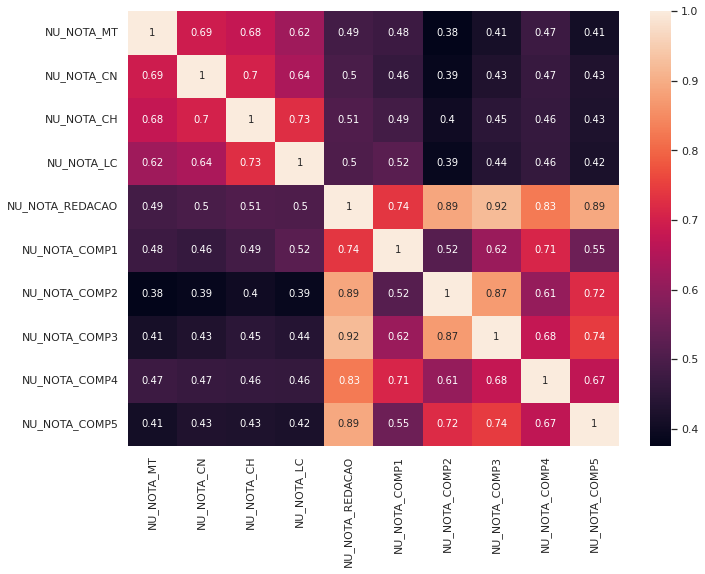

In [8]:
corr = df[features_corr].corr()
ax = plt.subplots(figsize=(11, 8))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10});

A matriz nos fornece informações de correlação entre os dados referentes às notas nas diferentes disciplinas. Podemos perceber que existe, grandes duas regiões: as relações entre as notas das provas objetivas e as relações entre as notas de redação e suas competências.

De fato, é esperado que exista uma forte correlação entre as notas das competências da redação e a nota final (uma vez que as competências compõem a nota final). Mas é interessante perceber que existe pouca correlação entre as notas de redação e as demais notas das provas objetivas.

### Verificando a distribuição de notas

Vamos agora ver como fica a distribuição de notas para cada disciplina dentro do nosso dataset. Isso vai nos ajudar na tarefa de agrupamento mais a frente.

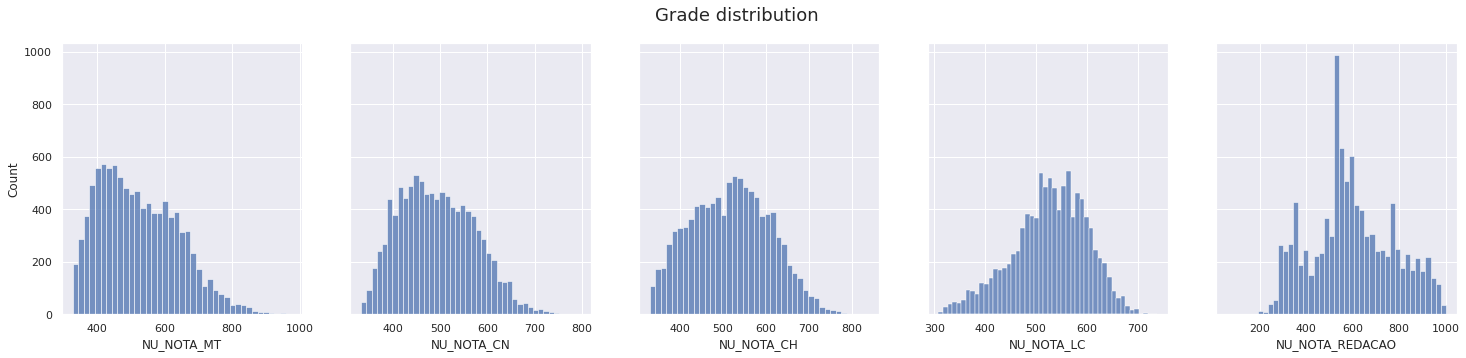

In [35]:
sns.set_theme()

fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
# fig.tight_layout()
fig.suptitle("Grade distribution", fontsize=18)

for idx,subject in enumerate(features_corr[:5]):
    g = sns.histplot(data=df[subject], ax=ax[idx]);

A partir dos histogramas, as notas de redação chamam a antenção por possuirem um formato de distribuição relativamente diferente das demais notas. É possível perceber três regiões de concentração de notas: a primeira são notas entre 300 e 400; a segunda são notas entre 500 e 650 (essa região apresenta a maior concentração); a terceira são de notas próximas de 800.

## Hipóteses

Antes de resolver os problemas propostos, foram pensadas algumas hipóteses que poderão (ou não) ser corroboradas ao final dos experimentos e análises:

1. Uma hipótese que pode ser levantada a partir disso é de que existem diferentes grupos de estudantes que obtiveram desempenho similar na parte objetiva da prova, mas que alcançaram resultados diferentes na redação (ou vice versa);

2. No agrupamento, esperamos que seja possível perceber grupos que compõem essas diferentes regiões de concentração de notas separadamente. Isso significa que esperamos ver grupos que possuem uma concentração de notas ao redor de 350, um outro grupo com notas próximas de 600 e um outro com notas ao redor de 800.

## Regressor

Uma vez que a proposta é a predição da nota de matemática nos baseando nas demais notas, nosso problema caracteriza uma tarefa clássica de regressão. Portanto, Partindo do conjunto de dados de treino iremos aplicar modelos de regressão baseado em árvores e avalir o modelo final utilizando o conjunto de teste.

### Transformando os dados

As notas da prova são compostos por notas entre 0 e ~1000, entretanto, é interessante notarmos que grande parte da população atinge notas ligeiramente diferentes nas  matérias aplicadas. Tendo em mente que grande parte dos modelos tem dificuldade de ajustar seus parâmetros para valores em ordem de grandezas diferentes, uma boa prática é utilizar de alguma padronização nos dados aproximando esses valores da origem, portanto, iremos aplicar o `StandardScaler` com esse intuito.

In [ ]:
# Separando os dados em teste e treino
p_train = 0.7
p_test = 1 - p_train

indices = np.random.randint(0, 10000, 10000)
df = df.iloc[indices, :]

train_df = df.iloc[:int(10000*p_train)]
test_df = df.iloc[int(10000*p_train):]

In [54]:
# Escolhe-se as notas de matemática
y_train = train_df['NU_NOTA_MT']
x_train = train_df[features]
x_test = test_df[features]
y_test = test_df['NU_NOTA_MT']

# Padronizando os dados
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [79]:
from sklearn.metrics import r2_score

# Função utilizada posteriormente para analisar os resultados dos regressores
def evaluate_regressor(regressor):
    regressor.fit(x_train, y_train);
    y_pred_test = regressor.predict(x_test);
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    print('R2:', r2_score(y_test, y_pred_test))

    results = pd.DataFrame([y_test.values, y_pred_test, np.abs(y_pred_test - y_test) > np.std(y_pred_test - y_test)]).transpose()
    results.columns = ['true', 'pred', 'in std']

    ax = sns.regplot(x=y_test, y=y_pred_test, scatter=False, color='#1596b3')
    sns.scatterplot(data=results, x='true', y='pred', ax=ax, hue='in std');

### Testando os regressores

Árvores de regressão são basicamente árvores de decisão utilizadas na tarefa de regressão, onde queremos predizer um valor contínuo em vez de um discreto como em uma classificação.

Nessa etapa iremos testar um algoritmo de aprendizagem supervisionada baseado em um ensemble de árvores de decisão, o random forest. Algumas métricas bem usuais de se analisar nesse tipo de tarefa e que foram adotados nesse trabalho são o erro médio absoluto (MAE), erro quadrático médio (MSE) e o erro quadrático médio da raiz (RMSE).

Também foi utilizado o coeficiente de determinação (R2) para analisar o modelo, sendo uma medida de ajuste de um modelo estatístico linear generalizado, variando de 0 a 1. Expressa a quantidade de variância dos dados que é explicada pelo modelo, portanto, quanto maior melhor.

#### Random forest

Random Forest
MAE: 46.05044493333336
MSE: 3616.500024878425
RMSE: 60.13734301478928
R2: 0.7309326514057266


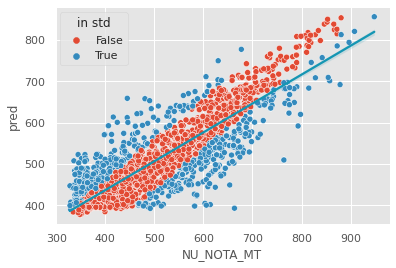

In [80]:
# Treina-se um modelo RandomForest
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor( 
           criterion='absolute_error', 
           max_depth=8,
           max_leaf_nodes=None,
           min_samples_leaf=1,
           min_samples_split=2,
           min_weight_fraction_leaf=0.0,
           n_estimators= 500,
           n_jobs=-1,
           random_state=0,
           verbose=0,
           warm_start=False
)

print('Random Forest')
evaluate_regressor(regressor)

Pelo gráfico do random forest vemos que os resultados são bem satisfatórios, uma vez que conseguimos capturar bem o comportamento dos resultados. Nota-se que para as notas mais baixas o modelo apresenta maior dificuldade de assimilar o comportamento, uma vez que os estudantes tendem a apresentar notas mais variadas em diferentes matérias nessa faixa de análise. Em contra parte indivíduos com notas elevadas tendem a manter um alto padrão em quase todas matérias o que permite uma melhor aderência do modelo.

O resultado do MAE também é bem interessante, o modelo erra em média em torno de 50 pontos, dentro do cenário de uma prova de 0 a 1000 pontos os resultados são muito bons.

#### XGBoost Regressor

O random forest apresentou resultados bem satisfatórios, entretanto, existem algoritmos mais sofisticados que são utilizados atualmente, como é o caso do `XGBoost regressor`.

O `XGboost` é uma biblioteca de código aberto, projetada para ser otimizada, veloz e flexivel que se basea em árvores de decisão, entretanto, utiliza uma estrutura de `gradient boosting` para obter resultados que algoritmos comuns tinham dificuldade de atingir, sendo obtidos através apenas de redes neurais.

XGBoost Regressor
MAE: 25.99527436726888
MSE: 1581.0416202389206
RMSE: 39.76231407047282
R2: 0.8823706141715895


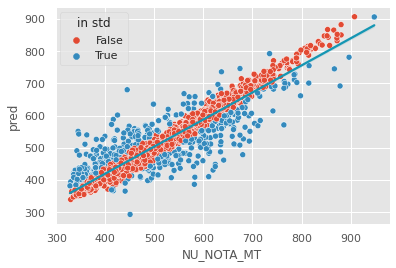

In [81]:
from xgboost import XGBRegressor

regressor = XGBRegressor()

print('XGBoost Regressor')
evaluate_regressor(regressor)

Assim como esperado o modelo foi bem performático, entretanto, vemos que seus resultados foram bem melhores que o modelo anterior, com quase metade do erro médio absoluto apresentado pelo random forest.

Esses resultados foram obtidos sem uma busca de hiperparâmetros que se adequem aos nossos dados, portanto, um `tuning` é um passo muito interessante nessa etapa. Para fazer essa otimização utilizamos o Optuna, um framework de otimização automática de hiperparâmetros para aprendizado de máquina. O Optuna pode construir espaços de busca de hiperparâmetros dinamicamente o que nos permite obter melhores valores de hiperparâmetros sem um número exorbitante de iterações.

### Otimizando os hiperparâmetros

In [68]:
from sklearn.metrics import mean_squared_error
import joblib
import os

def objective(trial):
    
    param = {
        # 'tree_method': 'gpu_hist',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  

    x_val = x_train[int(0.8*len(x_train)):]
    y_val = y_train[int(0.8*len(y_train)):]
    
    model.fit(
        x_train[:int(0.8*len(x_train))],
        y_train[:int(0.8*len(y_train))],
        eval_set=[(x_val, y_val)],
        early_stopping_rounds=100,
        verbose=False
    )
    
    preds = model.predict(x_val)
    
    rmse = mean_squared_error(y_val, preds, squared=False)
    
    return rmse
if not os.path.exists('study.pkl'):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    joblib.dump(study, 'study.pkl')
else:
    study = joblib.load('study.pkl')


[I 2022-03-21 02:06:49,353] A new study created in memory with name: no-name-bc7c523d-dbf2-4677-ad8d-ea02852a1390
[I 2022-03-21 02:07:15,106] Trial 0 finished with value: 52.545171847254586 and parameters: {'lambda': 0.00813845947258164, 'alpha': 0.0025084471761933355, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 81}. Best is trial 0 with value: 52.545171847254586.
[I 2022-03-21 02:07:38,592] Trial 1 finished with value: 65.6315840932055 and parameters: {'lambda': 0.015586398478986475, 'alpha': 2.475455403212141, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 201}. Best is trial 0 with value: 52.545171847254586.
[I 2022-03-21 02:08:06,067] Trial 2 finished with value: 57.82152112730502 and parameters: {'lambda': 0.6307182446828862, 'alpha': 0.015209698804894463, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.009, 'max_

O optuna nos permite visualizar uma série de plotagens do estudo de hiperparâmetros executado, entretanto, algumas plotagens podem conter redundâncias. Portanto, podemos visualizar de forma mais concisa o processo de `tuning` através do plot de histórico a seguir.

<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

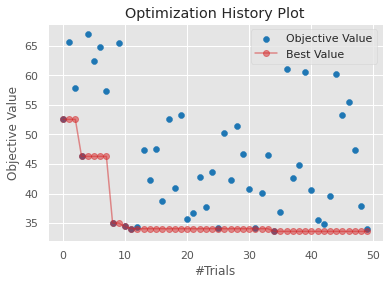

In [69]:
%%capture --no-display
optuna.visualization.matplotlib.plot_optimization_history(study);

Vemos que inicialmente o Optuna conseguiu melhorar significativamente os resultados do modelo, entretanto nos `trials` em torno de 8 para frente os hiperparâmetros já não melhoravam os resultados obtidos, indicando que em nossos dados o modelo não iria performar muito longe destes valores.

In [70]:
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  33.58281970634202
 Params: 
    lambda: 0.7561428776726224
    alpha: 2.0000075710679495
    colsample_bytree: 0.4
    subsample: 0.8
    learning_rate: 0.014
    max_depth: 20
    random_state: 2020
    min_child_weight: 2


Acima podemos ver os hiperparâmetros do Optuna para o melhor `trial` dentro do estudo. Portanto, serão esses valores que iremos utilizar para criar o modelo apresentado no restante deste trabalho.

# Resultados

MAE: 8.2225849995931
MSE: 715.8454649580797
RMSE: 26.755288541858032
R2: 0.9467411475364278


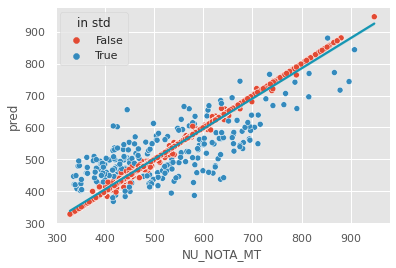

In [82]:
regressor = XGBRegressor(n_estimators = 4000, **study.best_trial.params)

evaluate_regressor(regressor)

Observa-se que os resultados obtidos com os hiperparâmetros propostos pelo Optuna foram significativamente melhores, tanto as métricas residuais quando a própria plotagem apresentaram valores muito mais próximos dos desejados. O Erro absoluto médio caiu novamente pela metade quando observado contra o modelo anterior, e vemos que os resultados preditos estão muito mais próximos da reta de predição, isto é, apresentaram um desvio bem menor.

Vale resltar também que o coeficiente de determinação obteve um valor acima de 0.9 o que é muito bom, uma vez que o R2 mede a variãncia dos dados explicada pelo modelo, isto é, o modelo consegue capturar muito bem o resultado final pelos dados de entrada.

Uma resultado muito interessante dos modelos baseados em árvores é que podemos observar a importância de cada uma das `features` na predição do modelo, no caso do XGboost podemos fazer isso de forma muito simples utilizando o atributo feature_importances_ do regressor.

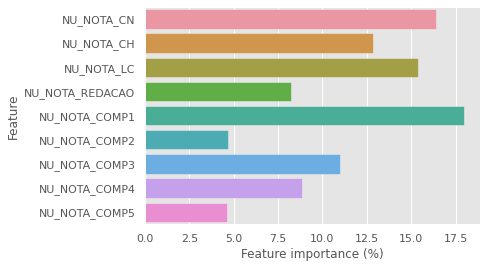

In [72]:
g = sns.barplot(y=features, x=100*regressor.feature_importances_);
g.set_xlabel('Feature importance (%)');
g.set_ylabel('Feature');

Nota-se que grande parte das `features` apresentaram valores próximos, ou pelo menos, nenhuma delas paresentou um valor muito inferior as outras, o que significa que o modelo utiliza todos dados de entrada adequadamente, isto é, não estamos inserindo features desnecessárias e causando um `overfitting`.

Os resultados acima são muito interessantes para entendermos como o modelo acredita que o comportamento é modelado, por exemplo, nesse cenário se acredita que alunos que tiram uma boa nota na competência 1 da redação obtem melhores notas em matemática que os demais, portanto, é um plot muito interessante para tirarmos vários `insights` e explicar o comportamento do problema.

## Agrupamento

Um estudo interessante com o conjunto de dados que podemos fazer é o agrupamento dos alunos utilizando suas notas e, posteriormente, utilizar as respostas do questionário para caracterizar cada grupo e observar se o algoritmo consegue capturar relações socioeconômicas distintas dos agrupamentos com apresentam notas maiores dos com notas menores.

Nesse contexto o AgglomerativeClustering é um algoritmo de agrupamento muito interessante, onde podemos ajusta-lo de forma visual facilmente caso os dados apresentem um forte comportamento de grupos.

In [39]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


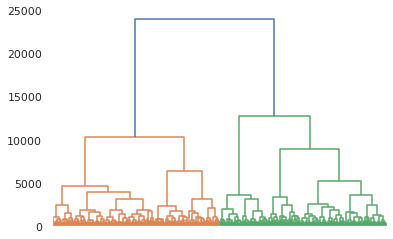

In [39]:
X = df[features_corr[:5]]

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(X.iloc[:, :5])

plot_dendrogram(model)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.show()

No dendrograma vemos que o algoritmo separa extremamente bem o conjunto em duas partes, entretanto, começa a ficar meio nebuloso para um valor maior de grupos.

Visualmente, vemos que um bom valor para o número de grupos seria algo em torna de 5, conseguindo separar bem os dados sem degenerar muito nossos grupos. Portanto, iremos utilizar 5 como o número de clusters e verificar como o algoritmo separa nossos dados.

In [40]:
X = df[features_corr[:5]]

model = AgglomerativeClustering(n_clusters=5)
model.fit(X.iloc[:, :5])

AgglomerativeClustering(n_clusters=5)

In [118]:
clusters = np.unique(model.labels_)
groups = []

for cluster in clusters:
    indices, = np.where(model.labels_ == cluster)
    group = df.iloc[indices, :]
    groups.append(df.iloc[indices, :])

In [24]:
grades = {column:[] for column in features_corr[:5]}

for group in groups:
    for column in features_corr[:5]:
        grades[column].append(group.loc[:, column].values)

# Resultados

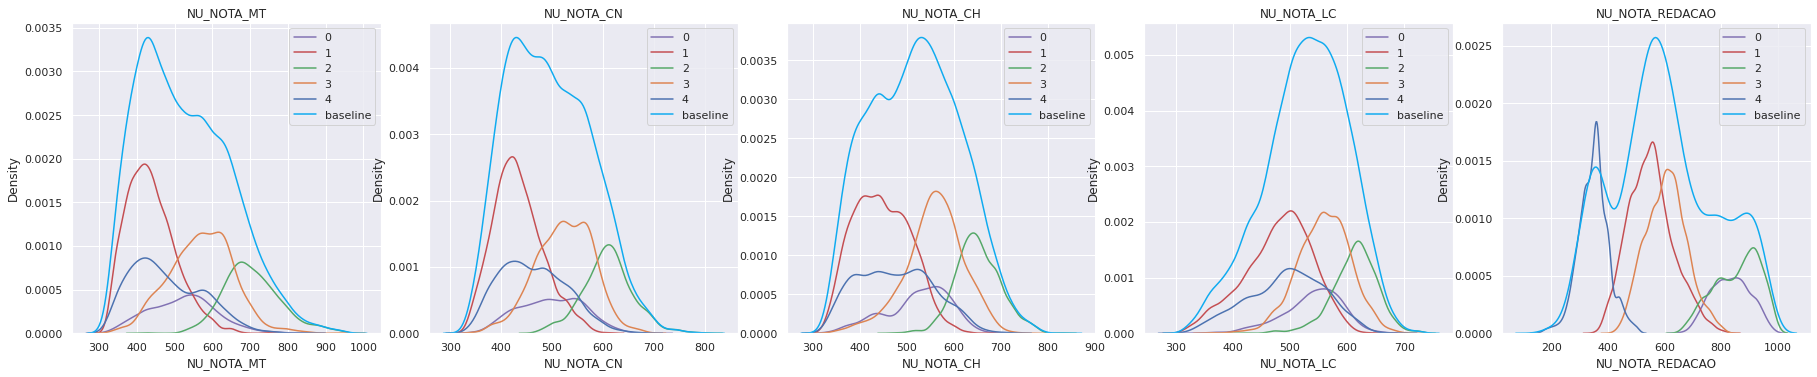

In [25]:
sns.set_theme()
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
fig.tight_layout()

for idx, column in enumerate(features_corr[:5]):
    ax[idx].set_title(column)
    sns.kdeplot(data=grades[column], ax=ax[idx]);
    sns.kdeplot(data=df[column], ax=ax[idx], color='#0fabf0');
    ax[idx].legend([0, 1, 2, 3, 4, 'baseline'])

Dos grupos encontrados pelo algoritmo, vemos um comportamento perto do que poderia ser esperado, isto é, temos um pequeno grupo com boas notas em praticamente todos assuntos, alguns grupos com notas baixas na maior parte da prova e a grande parte dos agrupamentos apresentam notas em torno da média em todas matérias, representando muito bem o resultado mediano da população no ENEM. Ainda que seja interessante conferirmos o comportamento dos agrupamentos para verificar sua coerência, o que realmente desejamos aqui é a caracterização destes grupos de acordo com a situação socioeconômica dos alunos.

In [184]:
social_features = ['TP_COR_RACA', 'TP_ESCOLA', 'SG_UF_ESC', 'Q006']
skin_color = ['Não declarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena']
school_kind = ['Não respondeu', 'Pública', 'Privada', 'Exterior']
income = [
    'Nenhuma Renda',
    'Até R$ 1.045,00',
    'R$ 1.045,01 - R$ 1.567,50',
    'R$ 1.567,51 - R$ 2.090,00',
    'R$ 2.090,01 - R$ 2.612,50',
    'R$ 2.612,51 - R$ 3.135,00',
    'R$ 3.135,01 - R$ 4.180,00',
    'R$ 4.180,01 - R$ 5.225,00',
    'R$ 5.225,01 - R$ 6.270,00',
    'R$ 6.270,01 - R$ 7.315,00',
    'R$ 7.315,01 - R$ 8.360,00',
    'R$ 8.360,01 - R$ 9.405,00',
    'R$ 9.405,01 - R$ 10.450,00',
    'R$ 10.450,01 - R$ 12.540,00',
    'R$ 12.540,01 - R$ 15.675,00',
    'R$ 15.675,01 - R$ 20.900,00',
    'Acima de R$ 20.900,00'
]

### Relação de raça

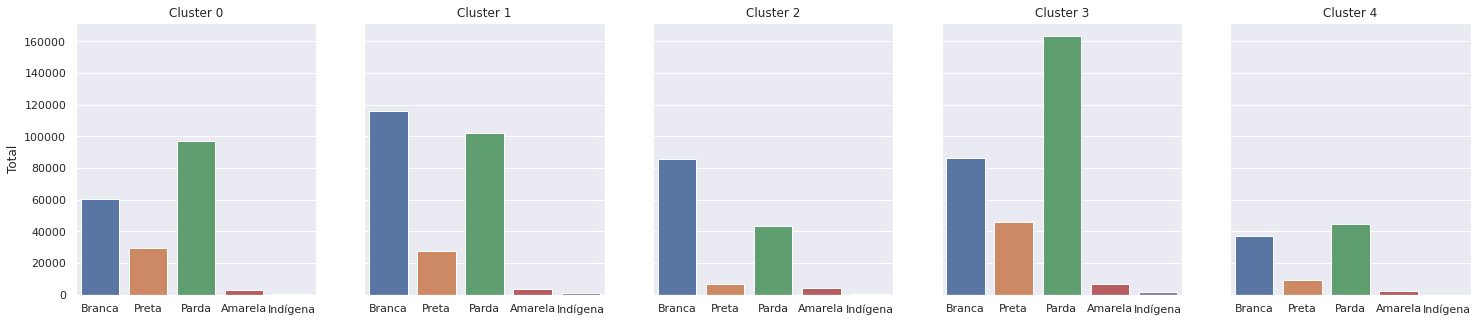

In [144]:
fig, ax = plt.subplots(ncols=5, figsize=(25, 5), sharey=True)
colors = sns.color_palette('pastel')[0:5]

for idx,group in enumerate(groups):
    count = np.zeros(6)
    g = group['TP_COR_RACA'].value_counts().sort_index()
    for i in g.index:
        count[i] = g[i]

    g = sns.barplot(x=skin_color[1:], y=100*count[1:], ax=ax[idx])
    g.set_title(f'Cluster {idx}')
    if idx == 0: g.set_ylabel('Total')
   

O que é interessante de notar nessa parte é que estamos tratando com dados quantitativos, portanto, em uma situação justa, os agrupamentos deveriam apresentar uma quantidade semelhante de indivíduos das mesmas raças, o que não ocorre. Como é possível observar o agrupamento com melhores notas apresentou a maior relação de brancos/pretos e até mesmo de brancos/pardos o que nos mostra a disparidade das notas dos indivíduos brancos em relação aos outros, indicando que esses indivíduos apresentam vantagens na prova em relação aos demais, ainda que esse critério não devesse influenciar na prova, mostrando uma falha em nosso país.

### Relação de tipo de escola

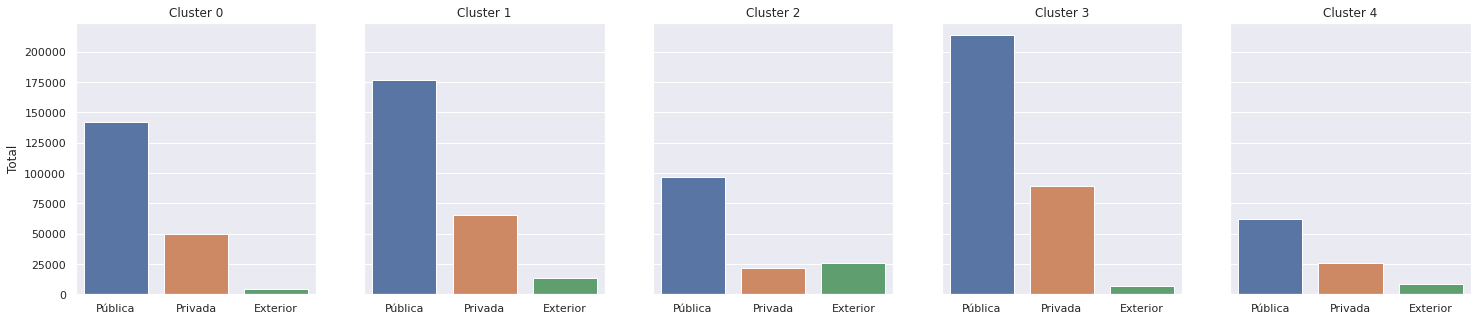

In [146]:
fig, ax = plt.subplots(ncols=5, figsize=(25, 5), sharey=True)
colors = sns.color_palette('pastel')[0:5]

for idx,group in enumerate(groups):
    count = np.zeros(4)
    g = group['TP_ESCOLA'].value_counts().sort_index()
    for i in g.index:
        count[i] = g[i]

    g = sns.barplot(x=school_kind[1:], y=100*count[1:], ax=ax[idx])
    g.set_title(f'Cluster {idx}')
    if idx == 0: g.set_ylabel('Total')

Um fato interessante de notar é que o agrupamento com melhores notas não foi o com maior quantidade de alunos de escola privada, como se poderia esperar em uma análise mais simples e sim o grupo com mais alunos do exterior, indicando que, possivelmente, as escolas fora do país ofertam um ensino melhor aos seus alunos até mesmo do que as escolas privadas no Brasil.

### Relação Renda Familiar

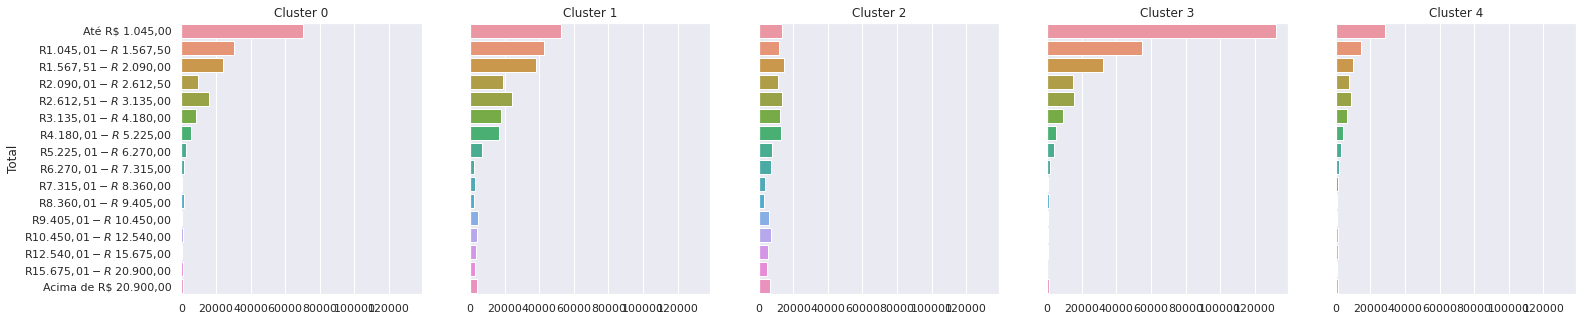

In [185]:
fig, ax = plt.subplots(ncols=5, figsize=(25, 5), sharex=True)
colors = sns.color_palette('pastel')[0:5]

for idx,group in enumerate(groups):
    g = group['Q006'].value_counts().sort_index()
    count = g.values
    labels = g.index

    g = sns.barplot(y=income[1:], x=100*count[1:], ax=ax[idx])
    if idx != 0:
        g.set(yticklabels=[])
    g.set_title(f'Cluster {idx}')
    if idx == 0: g.set_ylabel('Total')

Observa-se que a renda familiar tem grande influência nas notas dos estudantes, uma vez que vemos que o agrupamento com as maiores notas foi o que apresentou a maior quantidade de indivíduos com salários altos, ainda que visualmente poucos elementos, devemos lembrar que a maior parte da população no país possui uma renda relativamente baixa, portanto, o agrupamento com maior nota apresentar grande parte desses indivíduos com altos salários e pouquíssimos alunos com renda familiar baixa indica a disparidade do ensino que o aluno recebe devido a sua renda familiar.

# Conclusão

A partir dos resultados obtidos, observa-se que o propósito de aplicação foi atingido no geral. O `XGBRegressor` obteve resultados muito satisfatórios predizendo as notas de matemática dos alunos tomando como base as notas em outras modalidades, fortalecendo a hipótese de que as notas nos outros assuntos tem influência entre si e indicando que alunos com interesse em boas notas devem focar não em assuntos específicos mas sim na prova como um todo. Assim como o `AgglomerativeClustering` conseguiu separar os grupos como se era esperado, nos permitindo mostrar que existe uma forte relação socioeconômica nas notas que os alunos tiram.

A regressão das notas de matemática obtiveram um coeficiente de determinação altíssimo, acima de 0.9, uma vez que esse coeficiente varia dentro do intervalo real de 0 a 1, nosso modelo conseguiu explicar quase toda a variação dos dados tomando como entrada as outras notas. Portanto, é plausível dizer que alunos que tiram boas notas são consistentes em todas matérias, o que ainda fortalece a hipótese que um classificar com a finalidade de prever outra nota seria totalmente viável.

Já o agrupamento mostra a caracterização dos indivíduos baseados em suas notas, é interessante notarmos o fato que grande parte dos indivíduos que compôs o grupo com melhor nota era branco, estudou no exterior ou na escola privada e possui uma renda familiar e média bem maior em relação aos demais grupos, mostrando a necessidade da inclusão dos demais grupos, para permitir um acesso mais justo ao ensino superior.

Portanto, no geral os algoritmos aplicados desempenharam muito bem em um problema real mostra que as hipóteses desenhadas de antemão eram verdadeiras.